In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [17]:


# Define data transforms for train, validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}




In [18]:


# Define the dataset directory (adjust this path to your Kaggle input path)
data_dir = '/kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset'

# Create the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
print("Total images:", len(full_dataset))
class_names = full_dataset.classes
num_classes = len(class_names)

class_counts = {class_name: 0 for class_name in class_names}
for _, label in full_dataset.samples:
    class_counts[class_names[label]] += 1

print("Image count per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")



Total images: 16242
Image count per class:
Central Serous Chorioretinopathy-Color Fundus: 606
Diabetic Retinopathy: 3444
Disc Edema: 762
Glaucoma: 2880
Healthy: 2676
Macular Scar: 1937
Myopia: 2251
Pterygium: 102
Retinal Detachment: 750
Retinitis Pigmentosa: 834


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


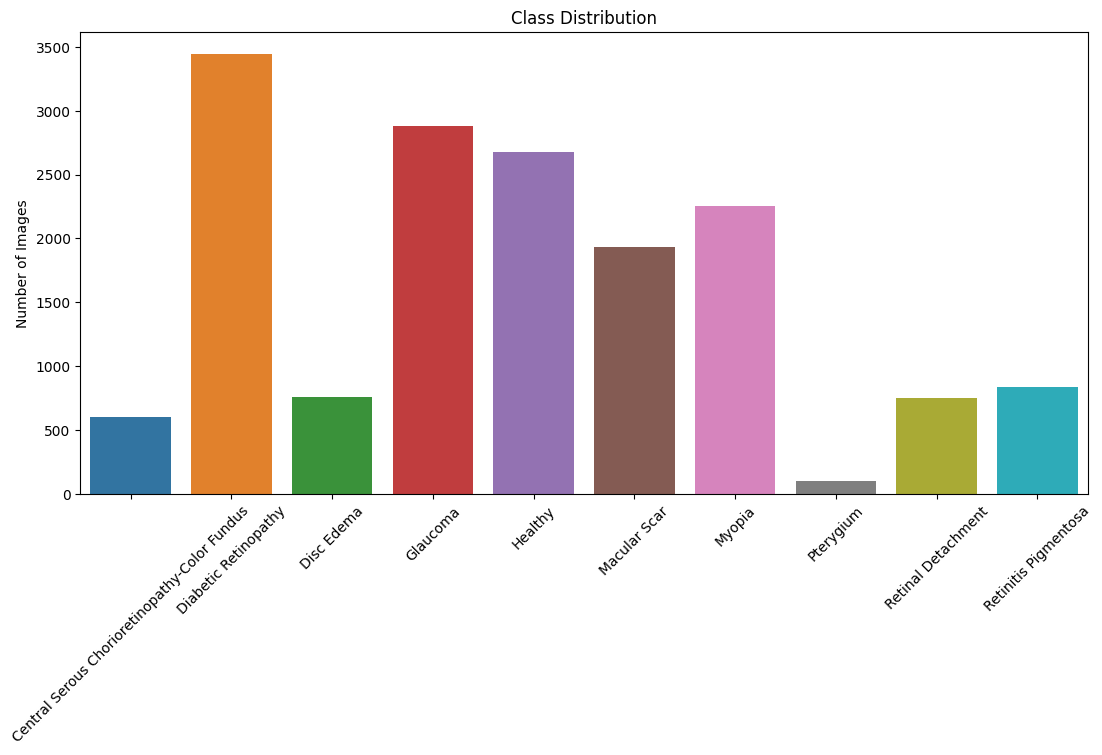

In [19]:
# Plot class distribution


plt.figure(figsize=(13, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.show()

In [20]:
# Split dataset: 70% train, 15% validation, 15% test
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size   = int(0.20 * dataset_size)
test_size  = dataset_size - train_size - val_size


In [21]:

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [22]:

val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

In [23]:

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))


Train size: 11369
Validation size: 3248
Test size: 1625


In [24]:

train_labels = [train_dataset.dataset.imgs[i][1] for i in train_dataset.indices]
# Compute class weights based on training labels
class_weights_np = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)
print("Class Weights:", class_weights)


Class Weights: tensor([ 2.7662,  0.4669,  2.1171,  0.5549,  0.6250,  0.8440,  0.7246, 15.7903,
         2.1780,  1.8699], device='cuda:0')


In [46]:
# For each training sample, assign a weight based on its label
sample_weights = [class_weights_np[label] for label in train_labels]
sample_weights = torch.tensor(sample_weights, dtype=torch.float)

In [47]:

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [48]:

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [49]:


# model = models.vgg16(pretrained=True)

# # Freeze the feature extractor
# for param in model.features.parameters():
#     param.requires_grad = False

# # Modify the classifier for our number of classes
# model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
# model = model.to(device)


model = models.vgg16(pretrained=True)

# Unfreeze the last convolutional block (last few layers)
for param in model.features[-4:].parameters():  # Unfreezing last 4 layers
    param.requires_grad = True

# Modify the classifier for our number of classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)


In [50]:

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer: Adam with a small learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [51]:

patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

In [52]:

num_epochs = 10  # Setting a higher number of epochs to let early stopping work
train_losses, val_losses = [], []
train_acc_history, val_acc_history = [], []



In [53]:

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Training Phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_losses.append(epoch_loss)
    train_acc_history.append(epoch_acc.item())
    
    # Validation Phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_val_loss = running_loss / val_size
    epoch_val_acc = running_corrects.double() / val_size
    val_losses.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # Optionally, save the best model weights here
        best_model_wts = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered. Stopping training.")
            break

Epoch 1/10
Train Loss: 0.3927 Acc: 0.6278 | Val Loss: 0.8031 Acc: 0.5988
Epoch 2/10
Train Loss: 0.1459 Acc: 0.8338 | Val Loss: 0.5308 Acc: 0.7814
Epoch 3/10
Train Loss: 0.1232 Acc: 0.8593 | Val Loss: 0.4852 Acc: 0.7752
Epoch 4/10
Train Loss: 0.2163 Acc: 0.7862 | Val Loss: 1.1321 Acc: 0.6450
Epoch 5/10


KeyboardInterrupt: 

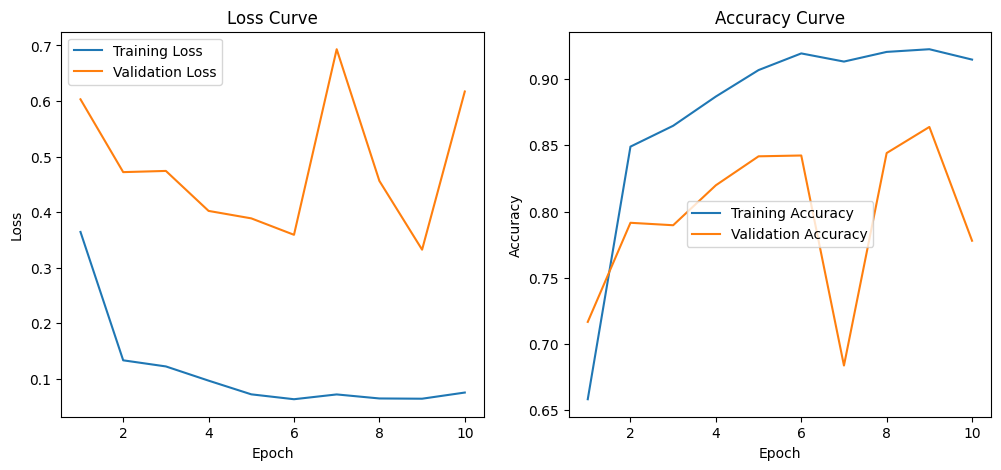

In [44]:

epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [37]:


model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
test_accuracy = np.mean(all_preds == all_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



Test Accuracy: 76.12%


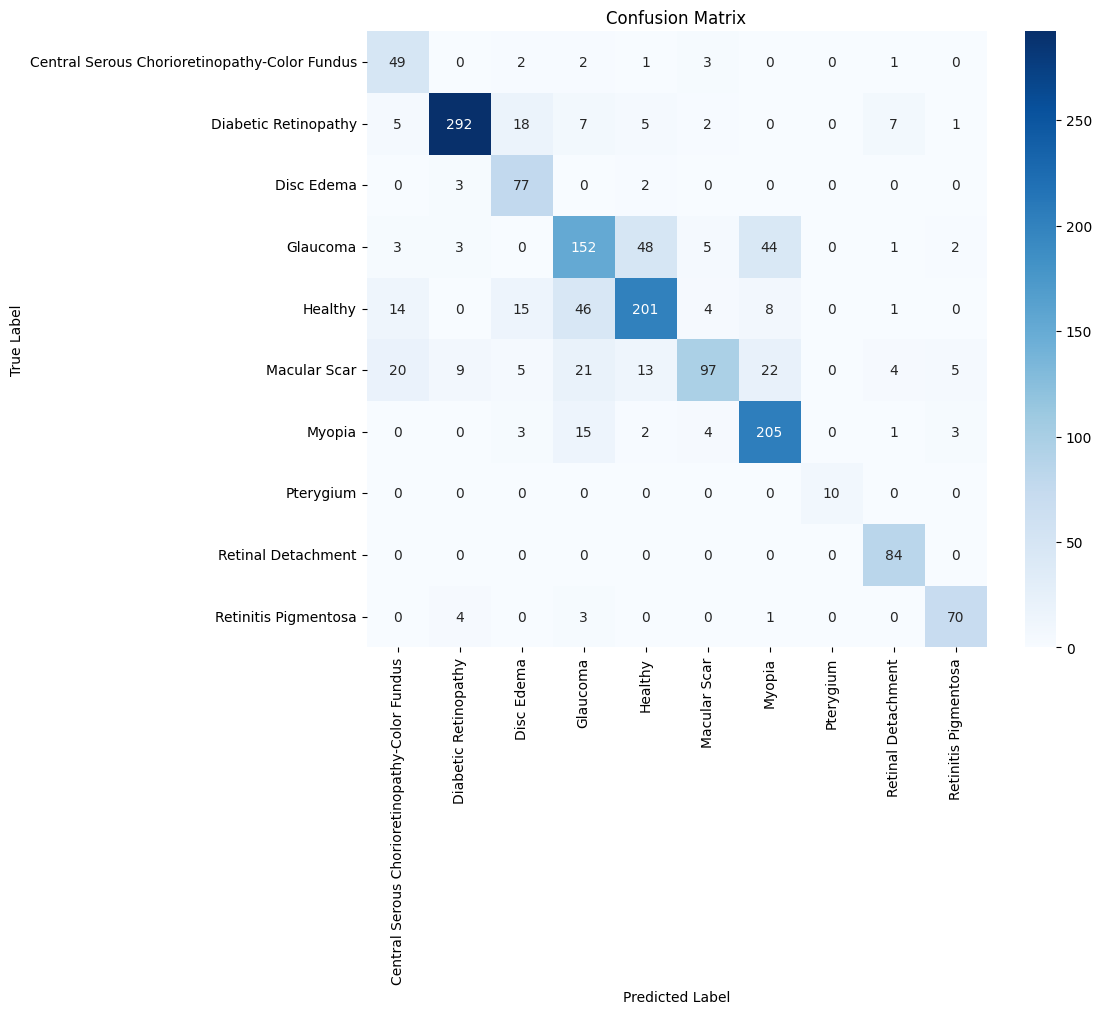

In [38]:


# -----------------------------------------------------------------------------
# Plot Confusion Matrix Heatmap
# -----------------------------------------------------------------------------

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
